# supernode-clustering

The procedure of supernode clustering with respect to various feature sets.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/infrastructure_features.json`
3. `data/features/graph_features.json`

Produces:
1. `data/clustering/supernode_clusters.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.linalg import LinAlgError
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from ptn.cluster_analysis import kmeans_inertia, dmdbscan, match_clusters, plot_clusters, \
    plot_separate_clusters, plot_cluster_features, get_one_vs_rest_cluster_statistics
from config import supernodes_fpath, infrastructure_features_fpath, graph_features_fpath, \
    supernode_clusters_fpath

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


In [4]:
coords = supernodes[['lon', 'lat']]

coords.head(2)

,lon,lat
id,,
0,30.322415,59.85171
1,30.287937,59.95021


In [5]:
infrastructure_features = pd.read_json(infrastructure_features_fpath).set_index('id')

total = infrastructure_features['total']
infrastructure_features = infrastructure_features.drop(columns=['total'])

infrastructure_features.head(2)

,Housing,Shopping,Restaurant,Services,Medicine,Education,Tourism,Fitness centre,Car service,Office building,Administrative,Grocery store,Hotel,Industrial area,Banking,Book shop,Post office,Religion,Shopping centre,Theatre
id,,,,,,,,,,,,,,,,,,,,
0,0.234609,0.247920,0.123128,0.071547,0.076539,0.034942,0.023295,0.054908,0.008319,0.008319,0.013311,0.021631,0.004992,0.003328,0.044925,0.021631,0.006656,0.000000,0.000000,0.0
1,0.185309,0.190317,0.180301,0.070117,0.085142,0.055092,0.068447,0.021703,0.010017,0.015025,0.030050,0.010017,0.021703,0.010017,0.011686,0.015025,0.006678,0.011686,0.001669,0.0


In [6]:
infr_mask = total > 0

(~infr_mask).sum()

84

In [7]:
infrastructure_features.notna().all().all()

True

In [8]:
graph_features = pd.read_json(graph_features_fpath).set_index('id')

graph_features = graph_features.dropna(axis=1)

connected = graph_features['is connected']
graph_features = graph_features.drop(columns=['is connected'])

graph_features -= graph_features.min()
graph_features /= graph_features.max() - graph_features.min()

graph_features.head(2)

,Betweenness centrality,Closeness centrality (hops),Closeness centrality (weight),Clustering,Degree centrality,PageRank
id,,,,,,
0,1.000000,0.971249,0.945417,0.000000,0.817805,0.943609
1,0.117568,0.855255,0.933214,0.107925,0.513458,0.520381


In [9]:
graph_mask = connected.astype(bool)

(~graph_mask).sum()

17

In [10]:
graph_features.notna().all().all()

True

## Clustering

### Infrastructure

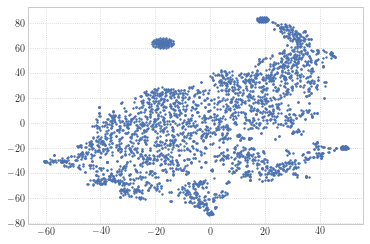

In [11]:
tsne = TSNE(random_state=0).fit_transform(infrastructure_features.values)
tsne = pd.DataFrame(tsne, index=infrastructure_features.index)

plt.scatter(*tsne.values.T, s=2)

__Warning!__ The following cluster numbering can differ if you run the code above on a different machine.

In [12]:
infrastructure_cluster_names = {
    2: 'Center',
    3: 'Residential area --- improved',
    4: 'Industrial area',
    0: 'Tourism area',
    1: 'Residential area --- unimproved',
    5: 'No infrastructure',
}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


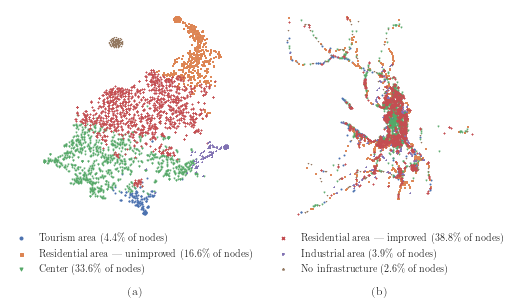

In [13]:
clusters_ = KMeans(n_clusters=5, random_state=0).fit_predict(infrastructure_features[infr_mask])

# clusters_ = DBSCAN(eps=0.2).fit_predict(infrastructure_features[infr_mask])
# clusters_[clusters_ == -1] = clusters_.max() + 1

infrastructure_clusters = pd.Series(clusters_.max() + 1, index=infrastructure_features.index)
infrastructure_clusters[infr_mask] = clusters_

plot_clusters(infrastructure_clusters, tsne, coords, infrastructure_cluster_names)

plt.savefig('../figures/infrastructure_clusters.jpg', dpi=300, bbox_inches='tight')

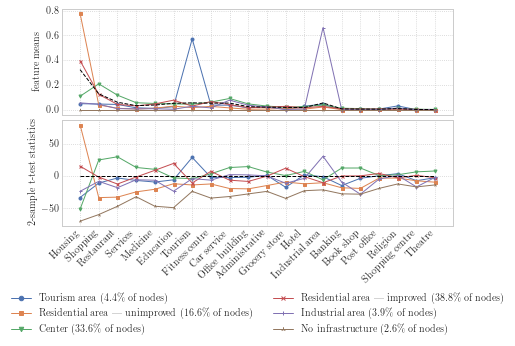

In [14]:
plot_cluster_features(
    features=infrastructure_features,
    clusters=infrastructure_clusters,
    cluster_names=infrastructure_cluster_names,
)

plt.savefig('../figures/infrastructure_cluster_features.jpg', dpi=300, bbox_inches='tight')

The 5 clusters can be interpreted as follows:

* Mainly tourist areas: tourism, restaurants, not much else (~140)
* "Good" residential areas: housing with schools, hospitals, shops nearby (~1240)
* "Bad" residential areas: housing with pretty much nothing nearby (~530)
* Industrial areas, fuel stations, other car-related stuff (~125)
* City center: not much housing, mainly shops, restaurants, services, banks etc. (~1070)

Additionally, we have a separate "cluster" of supernodes with no infrastructure objects around (~85).

"Industrial" stops on average have the smallest number (less than 20) of infrastructure objects around them. Tourism-related and "bad residential" stops follow with about 35-45 objects, "good residential" stops get around 40-50 objects, and the largest number of objects connects to the central stops (90-110). Note that the number of objects around a stop was not used in clustering (only fractions of various kinds of objects), so such correspondence seems reasonable.

In [15]:
clusters = pd.DataFrame({'infr_cl': infrastructure_clusters})
clusters['infr_cl_name'] = clusters['infr_cl'].apply(infrastructure_cluster_names.get)

clusters.head(2)

,infr_cl,infr_cl_name
id,,
0,2,Center
1,2,Center


### Topology

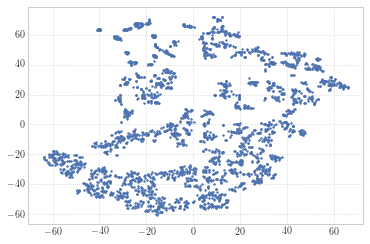

In [16]:
tsne = TSNE(random_state=0).fit_transform(graph_features.values)
tsne = pd.DataFrame(tsne, index=graph_features.index)

plt.scatter(*tsne.values.T, s=2)

In [17]:
graph_cluster_names = {
    4: 'Hub',
    1: 'Center',
    0: 'Inaccessible center',
    3: 'Suburbs',
    2: 'Towns',
    5: 'Disconnected',
}

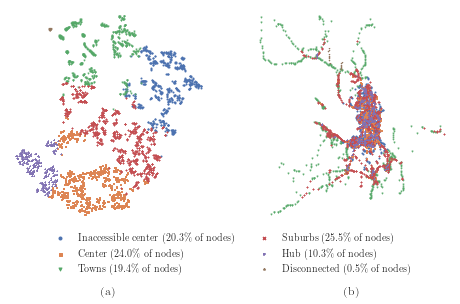

In [18]:
clusters_ = KMeans(n_clusters=5, random_state=0).fit_predict(graph_features[graph_mask])

# clusters_ = DBSCAN(eps=0.012).fit_predict(graph_features[graph_mask])
# clusters_[clusters_ == -1] = clusters_.max() + 1

graph_clusters = pd.Series(clusters_.max() + 1, index=graph_features.index)
graph_clusters[graph_mask] = clusters_

plot_clusters(graph_clusters, tsne, coords, graph_cluster_names)

plt.savefig('../figures/graph_clusters.jpg', dpi=300, bbox_inches='tight')

In [19]:
df = graph_features[graph_mask].copy()

df.columns = ['Btwn. centr.', 'Clos. centr. (hops)',
              'Clos. centr. (weight)', 'Clustering', 'Degree centr.',
              'PageRank']

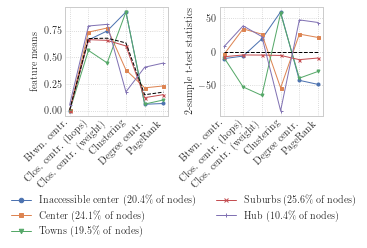

In [20]:
plot_cluster_features(
    features=df,
    clusters=graph_clusters[graph_mask],
    cluster_names=graph_cluster_names,
    orient='h',
)

plt.savefig('../figures/graph_cluster_features.jpg', dpi=300, bbox_inches='tight')

In [22]:
clusters['graph_cl'] = graph_clusters
clusters['graph_cl_name'] = clusters['graph_cl'].apply(graph_cluster_names.get)

clusters.head(2)

,infr_cl,infr_cl_name,graph_cl,graph_cl_name
id,,,,
0,2,Center,4,Hub
1,2,Center,4,Hub


In [23]:
contingency_table = pd.crosstab(clusters['infr_cl_name'], clusters['graph_cl_name'])

contingency_table.index.name = None
contingency_table.columns.name = None

contingency_table

,Center,Disconnected,Hub,Inaccessible center,Suburbs,Towns
Center,300,3,169,265,225,115
Industrial area,3,0,0,33,43,47
No infrastructure,0,3,0,2,11,68
Residential area --- improved,371,2,144,249,344,131
Residential area --- unimproved,74,9,15,92,139,203
Tourism area,20,0,2,10,54,56


In [24]:
with open('../tables/contingency_table.tex', 'w') as file:
    file.write(contingency_table.to_latex())

### Concatenated features

In [25]:
clusters_json = []

for i, row in clusters.iterrows():
    item = {'id': i}
    item.update(row.to_dict())
    
    clusters_json.append(item)
    
clusters_json[0]

{'id': 0,
 'infr_cl': 2,
 'infr_cl_name': 'Center',
 'graph_cl': 4,
 'graph_cl_name': 'Hub'}

In [26]:
save_json(clusters_json, supernode_clusters_fpath)